# RFP Data Preprocessing

This notebook prepares a pool of starting RFP wild variants with known structure for optimization.

In [1]:
import pandas as pd
import pypdb
import requests
import json
import time
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from botorch.utils.multi_objective import pareto
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from Bio.PDB.PDBList import PDBList
from Bio import PDB
from Bio.SeqUtils import seq1

from lambo.candidate import pdb_to_residues, FoldedCandidate
from lambo.tasks.proxy_rfp.foldx import FoldxManager, extract_chain
from lambo.utils import ResidueTokenizer

import warnings
warnings.filterwarnings("ignore")

sns.set(style='whitegrid', font_scale=1.75)

FPBASE_ENDPOINT = "https://www.fpbase.org/api/proteins/?"

## Merge name and sequence csv files
Keep only 'red' proteins (at least 580 nm emission wavelength)

In [2]:
fpbase_names = pd.read_csv('../lambo/assets/fpbase/fpbase_names.csv')
fpbase_seqs =  pd.read_csv('../lambo/assets/fpbase/fpbase_sequences.csv')
select_cols = ['Name', 'Seq', 'num_mutations']
fpbase_seqs = fpbase_seqs[select_cols]

fpbase_data = fpbase_names.merge(fpbase_seqs, on='Name', how='inner')  # combine csv files
rfp_data = fpbase_data[fpbase_data['Em max (nm)'] >= 580]  # only keep "red" proteins
rfp_data.reset_index(drop=True, inplace=True)

rfp_data.head()

,Name,Ex max (nm),Em max (nm),Stokes Shift (nm),Extinction Coefficient,Quantum Yield,Brightness,pKa,Oligomerization,Maturation (min),Lifetime (ns),Molecular Weight (kDa),Switch Type,Aliases,Seq,num_mutations
0,RRvT,556.0,583.0,27.0,134000,0.88,117.92,3.9,td,NaN,NaN,54.55,b,NaN,MVSKGEEVIKEFMRFKVRMEGSMNGHEFEIEGEGEGRPYEGTQTAK...,358
1,tdTomato,554.0,581.0,27.0,138000,0.69,95.22,4.7,td,60.0,NaN,54.19,b,NaN,MVSKGEEVIKEFMRFKVRMEGSMNGHEFEIEGEGEGRPYEGTQTAK...,356
2,FusionRed-MQV,566.0,585.0,19.0,144000,0.53,76.32,4.6,m,195.0,2.77,25.59,b,FR-MQV,MVSELIKENMPMKLYMEGTVNNHHFKCTSEGEGKPYEGTQTQRIKV...,181
3,pcDronpa2 (Red),569.0,583.0,14.0,105000,0.68,71.40,6.1,t,NaN,NaN,25.34,mp,NaN,MSVIKPDMKIKLRMEGAVNGHPFAIEGVGLGKPFEGKQSMDLKVKE...,174
4,mScarlet,569.0,594.0,25.0,100000,0.70,70.00,5.3,m,174.0,3.90,26.35,b,NaN,MVSKGEAVIKEFMRFKVHMEGSMNGHEFEIEGEGEGRPYEGTQTAK...,165


## Get PDB ids for proteins with known structure from FPBase
If multiple structures are available use the highest-resolution structure.

Record crystal pH value for FoldX repair.

In [3]:
def fpbase_name_to_pdb_ids(name):
    name = name.split(' ')[0]
    print(f'---- {name} ----')
    query = f'{FPBASE_ENDPOINT}name__iexact={name}&format=json'
    response = requests.get(query)
    if not response.status_code == 200:
        print('query failed')
        return []
    
    query_results = json.loads(response.text)[0]['pdb']
    
    def get_resolution(info):
        try:
            return info['rcsb_entry_info']['resolution_combined'][0]
        except KeyError:
            return float('NaN')
        
    def get_pH(info):
        try:
            return info['exptl_crystal_grow'][0]['p_h']
        except KeyError:
            return float('NaN')
    
    if len(query_results) > 0:
        entry_info = [pypdb.get_info(pdb_id) for pdb_id in query_results]
        resolution = [get_resolution(info) for info in entry_info]
        pH = [get_pH(info) for info in entry_info]
        query_results = [
            (pdb_id, res, ph) for pdb_id, res, ph in zip(query_results, resolution, pH)
        ]
        query_results.sort(key=lambda datum: datum[1])
    
    return query_results


for row_idx, datum in rfp_data.iterrows():
    query_results = fpbase_name_to_pdb_ids(datum.Name)
    time.sleep(0.1)
    if len(query_results) == 0:
        continue
        
    rfp_data.loc[row_idx, 'pdb_id'] = query_results[0][0]
    rfp_data.loc[row_idx, 'pdb_resolution'] = query_results[0][1]
    rfp_data.loc[row_idx, 'crystal_pH'] = query_results[0][2]

---- RRvT ----
---- tdTomato ----
---- FusionRed-MQV ----
---- pcDronpa2 ----
---- mScarlet ----
---- GRvT ----
---- plobRFP ----
---- AzaleaB5 ----
---- mRuby3 ----
---- RFP611 ----
---- mScarlet-I ----
---- ccalRFP1 ----
---- pporRFP ----
---- pcDronpa ----
---- DsRed ----
---- tdKatushka2 ----
---- TagRFP ----
---- dTomato ----
---- M355NA ----
---- cgfTagRFP ----
---- amilFP593 ----
---- mEos4a ----
---- mRuby2 ----
---- mEos4b ----
---- mRuby ----
---- mApple ----
---- GRvT ----
---- CyRFP1 ----
---- E2-Red/Green ----
---- eqFP611 ----
---- TagRFP-T ----
---- td-RFP611 ----
---- smURFP ----
---- TDsmURFP ----
---- CyOFP1 ----
---- mEos2 ----
---- Katushka2S ----
---- DsRed.T3 ----
---- E2-Crimson ----
---- FR-1 ----
---- DsRed2 ----
---- PATagRFP1314 ----
---- PATagRFP1297 ----
---- mStrawberry ----
---- cgfmKate2 ----
---- PATagRFP ----
---- mKate2 ----
---- d1EosFP ----
---- FusionRed-M ----
---- mEosFP ----
---- KikGR1 ----
---- mNeptune2.5 ----
---- EosFP ----
---- Katushka --

## Clean up dataframe

In [4]:
rfp_data.crystal_pH.fillna(7.0, inplace=True)
rfp_known_structures = rfp_data.dropna(subset=['pdb_id'])
rfp_known_structures.drop_duplicates(subset=['pdb_id'], inplace=True, keep=False)
rfp_known_structures.sort_values('Name', inplace=True)
rfp_known_structures.rename(columns={'Seq': 'fpbase_seq'}, inplace=True)

for _, datum in rfp_known_structures.iterrows():
    print(f'{datum.Name}: {datum.pdb_id} ({datum.pdb_resolution} nm)')

AdRed: 6AA7 (1.8 nm)
DrCBD: 1ztu (2.5 nm)
DsRed: 1ZGO (1.4 nm)
DsRed-Max: 2V4E (2.4 nm)
DsRed.M1: 2VAD (1.59 nm)
DsRed.T4: 2VAE (1.64 nm)
HcRed: 1YZW (2.1 nm)
HcRed7: 6DEJ (1.6279 nm)
IrisFP (Orange): 2VVH (1.8 nm)
Katushka: 3PJ5 (1.6 nm)
KikGR1 (Red): 4P76 (2.9 nm)
KillerRed: 3GB3 (1.75 nm)
LSS-mKate1: 3NT9 (1.99 nm)
LSS-mKate2: 3NT3 (1.5 nm)
Neptune: 3IP2 (1.6 nm)
PSmOrange (Far-red): 4Q7T (1.94 nm)
PSmOrange2 (Far-red): 4Q7U (1.3 nm)
RCaMP: 3U0K (2.1 nm)
RFP630: 3E5V (2.1 nm)
Sandercyanin: 5EZ2 (1.849 nm)
TagRFP: 3M22 (2.2 nm)
TagRFP-T: 5JVA (1.95 nm)
TagRFP675: 4KGE (2.3 nm)
Wi-Phy: 3S7Q (1.748 nm)
asulCP: 1XQM (2.1 nm)
cp-mKate: 3RWA (1.67 nm)
eqFP611: 1UIS (2.0 nm)
eqFP650: 4EDO (1.8 nm)
eqFP670: 4EDS (1.6 nm)
iFP1.4: 5AJG (1.11 nm)
iFP2.0: 4CQH (1.14 nm)
laRFP: 4JF9 (2.33 nm)
mCRISPRed: 6XWY (1.75 nm)
mCardinal: 4OQW (2.21 nm)
mCherry: 2H5Q (1.36 nm)
mEos2 (Red): 3S05 (2.204 nm)
mEos2-A69T (Orange): 5DTL (2.7 nm)
mEosFP (Red): 3P8U (2.25 nm)
mKate: 3BXA (1.75 nm)
mPlum: 2QLG (1.

## Download structures from RCSB PDB

In [5]:
pdb_list = PDBList()
pdb_list.download_pdb_files(
    rfp_known_structures.pdb_id,
    pdir='../lambo/assets/pdb',
    file_format="pdb"
)

## Extract longest chain in the structure
Break ties with chain ID (i.e. use chain A by default)

In [6]:
for row_idx, datum in rfp_known_structures.iterrows():
    pdb_path = f'../lambo/assets/pdb/pdb{datum.pdb_id.lower()}.ent'
    parser = PDB.PDBParser()
    pdb_path = Path(pdb_path)
    struct = parser.get_structure(pdb_path.stem, pdb_path)
    chain_residues = {
        chain.get_id(): seq1(''.join(x.resname for x in chain)) for chain in struct.get_chains()
    }
    chain_lengths = [
        (-len(seq.replace('X', '')), chain_id) for chain_id, seq in chain_residues.items()
    ]
    chain_lengths.sort()
    longest_chain = chain_lengths[0][1]
    rfp_known_structures.loc[row_idx, 'longest_chain'] = longest_chain
    extract_chain(pdb_path, longest_chain)

rfp_known_structures.longest_chain.value_counts()

A    41
B     5
C     3
D     1
Name: longest_chain, dtype: int64

## Repair single-chain structures with FoldX

In [7]:
for _, datum in rfp_known_structures.iterrows():
    pdb_path = f'../lambo/assets/pdb/pdb{datum.pdb_id.lower()}_{datum.longest_chain}.pdb'
    work_dir = f'../lambo/assets/foldx/{datum.pdb_id.lower()}_{datum.longest_chain}/'
    print(f'---- {datum.Name}-{datum.longest_chain} ----')
    if os.path.exists(Path(work_dir) / 'wt_input_Repair.pdb'):
        print('file exists, skipping')
        continue
    else:
        os.makedirs(work_dir, exist_ok=True)
        FoldxManager(work_dir=work_dir, wt_pdb=pdb_path, skip_minimization=False,
                     ph=datum.crystal_pH)

---- AdRed-A ----
file exists, skipping
---- DrCBD-A ----
file exists, skipping
---- DsRed-A ----
file exists, skipping
---- DsRed-Max-B ----
file exists, skipping
---- DsRed.M1-A ----
file exists, skipping
---- DsRed.T4-A ----
file exists, skipping
---- HcRed-A ----
file exists, skipping
---- HcRed7-A ----
file exists, skipping
---- IrisFP (Orange)-C ----
file exists, skipping
---- Katushka-A ----
file exists, skipping
---- KikGR1 (Red)-A ----
file exists, skipping
---- KillerRed-A ----
file exists, skipping
---- LSS-mKate1-A ----
file exists, skipping
---- LSS-mKate2-C ----
file exists, skipping
---- Neptune-A ----
file exists, skipping
---- PSmOrange (Far-red)-B ----
file exists, skipping
---- PSmOrange2 (Far-red)-A ----
file exists, skipping
---- RCaMP-A ----
file exists, skipping
---- RFP630-A ----
file exists, skipping
---- Sandercyanin-A ----
file exists, skipping
---- TagRFP-A ----
file exists, skipping
---- TagRFP-T-A ----
file exists, skipping
---- TagRFP675-A ----
file exist

## Validate repaired FoldX sequences
Compare against FPBase and corresponding NCSB PDB chain. They won't match exactly.

In [8]:
for row_idx, datum in rfp_known_structures.iterrows():
    fpbase_seq = datum.fpbase_seq
    
    pdb_path = f'../lambo/assets/pdb/pdb{datum.pdb_id.lower()}.ent'
    rcsb_seq, _ = pdb_to_residues(pdb_path, datum.longest_chain)
    rcsb_seq = rcsb_seq.replace('X', '')
    
    pdb_path = f'../lambo/assets/foldx/{datum.pdb_id.lower()}_{datum.longest_chain}/wt_input_Repair.pdb'
    foldx_seq, _ = pdb_to_residues(pdb_path, datum.longest_chain)
    rfp_known_structures.loc[row_idx, 'foldx_seq'] = str(foldx_seq)
    
    print(f'\n---- {datum.Name}-{datum.pdb_id}-{datum.longest_chain} ----')
    print(f'FPBase ({len(fpbase_seq)} residues): {fpbase_seq}\n')
    print(f'FoldX ({len(foldx_seq)} residues): {foldx_seq}\n')


---- AdRed-6AA7-A ----
FPBase (231 residues): MALSKHGLTKDMTMKYRMEGCVDGHKFVITGHGNGSPFEGKQTINLCVVEGGPLPFSEDILSAVFDYGNRVFTDYPQGMVDFFKNSCPAGYTWQRSLLFEDGAVCTASADITVSVEENCFYHESKFHGVNFPADGPVMKKMTINWEPCCEKIIPVPRQGILKGDVAMYLLLKDGGRYRCQFDTVYKAKTDSKKMPEWHFIQHKLTREDRSDAKNQKWQLAEHSVASRSALP

FoldX (226 residues): LSKHGLTKDMTMKYRMEGCVDGHKFVITGHGNGSPFEGKQTINLCVVEGGPLPFSEDILSAVFNRVFTDYPQGMVDFFKNSCPAGYTWQRSLLFEDGAVCTASADITVSVEENCFYHESKFHGVNFPADGPVMKKMTINWEPCCEKIIPVPRQGILKGDVAMYLLLKDGGRYRCQFDTVYKAKTDSKKMPEWHFIQHKLTREDRSDAKNQKWQLAEHSVASRSALA


---- DrCBD-1ztu-A ----
FPBase (321 residues): MSRDPLPFFPPLYLGGPEITTENCEREPIHIPGSIQPHGALLTADGHSGEVLQMSLNAATFLGQEPTVLRGQTLAALLPEQWPALQAALPPGCPDALQYRATLDWPAAGHLSLTVHRVGELLILEFEPTEAWDSTGPHALRNAMFALESAPNLRALAEVATQTVRELTGFDRVMLYKFAPDATGEVIAEARREGLHAFLGHRFPASDIPAQARALYTRHLLRLTADTRAAAVPLDPVLNPQTNAPTPLGGAVLRATSPMHMQYLRNMGVGSSLSVSVVVGGQLWGLIACHHQTPYVLPPDLRTTLEYLGRLLSLQVQVKEA

FoldX (313 residues): PLPFFPPLYLGGPEITTENCEREPIHIPGSIQPHGALLTADGHSGEVLQMSLNAATFLGQEPTVLRGQTLAALLPEQW


---- Sandercyanin-5EZ2-A ----
FPBase (170 residues): MFIKPGRCPKPAVQEDFDAARYLGVWYDIQRLPNKFQKGECATATYSLSPGVGFSVFNRERLANGTIKSVIGSAIAEDPCEPAKLQFFHENAAPVPYWVLSTDYDNYALVYSCINLGASHAAYASIVSRQPTLPEETIKKLQGTMSSFGVGVDTLLTTNQDAAYCSAMNQ

FoldX (169 residues): MFIKPGRCPKPAVQEDFDAARYLGVWYDIQRLPNKFQKGECATATYSLSPGVGFSVFNRERLANGTIKSVIGSAIAEDPCEPAKLQFFHENAAPVPYWVLSTDYDNYALVYSCINLGASHAAYASIVSRQPTLPEETIKKLQGTMSSFGVGVDTLLTTNQDAAYCSAMN


---- TagRFP-3M22-A ----
FPBase (231 residues): MSELIKENMHMKLYMEGTVNNHHFKCTSEGEGKPYEGTQTMRIKVVEGGPLPFAFDILATSFMYGSRTFINHTQGIPDFFKQSFPEGFTWERVTTYEDGGVLTATQDTSLQDGCLIYNVKIRGVNFPSNGPVMQKKTLGWEANTEMLYPADGGLEGRSDMALKLVGGGHLICNFKTTYRSKKPAKNLKMPGVYYVDHRLERIKEADKETYVEQHEVAVARYCDLPSKLGHK

FoldX (223 residues): ELIKENMHMKLYMEGTVNNHHFKCTSEGEGKPYEGTQTMRIKVVEGGPLPFAFDILATSFSRTFINHTQGIPDFFKQSFPEGFTWERVTTYEDGGVLTATQDTSLQDGCLIYNVKIRGVNFPSNGPVMQKKTLGWEANTEMLYPADGGLEGRSDMALKLVGGGHLICNFKTTYRSKKPAKNLKMPGVYYVDHRLERIKEADKETYVEQHEVAVARYCDLPSKL


---- TagRFP-T-5JVA-A ----
FPBase (244 residues): MVS


---- mEos2-A69T (Orange)-5DTL-A ----
FPBase (226 residues): MSAIKPDMKIKLRMEGNVNGHHFVIDGDGTGKPFEGKQSMDLEVKEGGPLPFAFDILTTAFHYGNRVFTKYPDNIQDYFKQSFPKGYSWERSLTFEDGGICIARNDITMEGDTFYNKVRFYGTNFPANGPVMQKKTLKWEPSTEKMYVRDGVLTGDIHMALLLEGNAHYRCDFRTTYKAKEKGVKLPGYHFVDHCIEILSHDKDYNKVKLYEHAVAHSGLPDNARR

FoldX (219 residues): SAIKPDMKIKLRMEGNVNGHHFVIDGDGTGKPFEGKQSMDLEVKEGGPLPFAFDILTTAFNRVFTKYPDNIQDYFKQSFPKGYSWERSLTFEDGGICIARNDITMEGDTFYNKVRFYGTNFPANGPVMQKKTLKWEPSTEKMYVRDGVLTGDIHMALLLEGNAHYRCDFRTTYKAKEKGVKLPGYHFVDHCIEILSHDKDYNKVKLYEHAVAHSGLPDN


---- mEosFP (Red)-3P8U-C ----
FPBase (226 residues): MSAIKPDMKINLRMEGNVNGHHFVIDGDGTGKPFEGKQSMDLEVKEGGPLPFAFDILTTAFHYGNRVFAEYPDHIQDYFKQSFPKGYSWERSLTFEDGGICIARNDITMEGDTFYNKVRFHGTNFPANGPVMQKKTLKWEPSTEKMYVRDGVLTGDIHMALLLEGNAHYRCDFRTTYKAKEKGVKLPGYHFVDHCIEILSHDKDYNKVKLYEHAVAHSGLPDNARR

FoldX (222 residues): HHMSAIKPDMKINLRMEGNVNGHHFVIDGDGTGKPFEGKQSMDLEVKEGGPLPFAFDILTTAFNRVFAEYPDHIQDYFKQSFPKGYSWERSLTFEDGGICIARNDITMEGDTFYNKVRFHGTNFPANGPVMQKKTLKWEPSTEKMYVRDGVLTGDIHMALLLEG

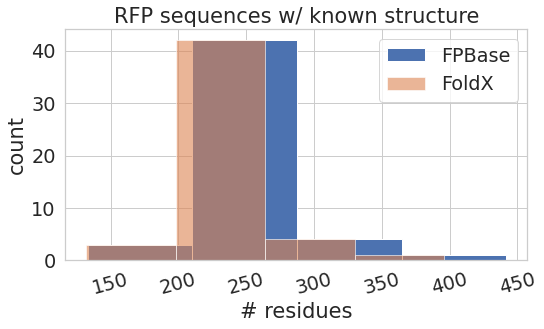

In [10]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

plt.hist(rfp_known_structures.fpbase_seq.apply(lambda seq: len(seq)), label='FPBase',
         zorder=1, bins=4)
plt.hist(rfp_known_structures.foldx_seq.apply(lambda seq: len(seq)), label='FoldX',
         alpha=0.6, zorder=2, bins=4)
plt.xticks(rotation='15')
ax.legend()
ax.set_xlabel('# residues')
ax.set_ylabel('count')
ax.set_title('RFP sequences w/ known structure')
plt.tight_layout()
# plt.savefig('./figures/rfp_known_structures_seq_len_plot.pdf')

## Estimate total energy and SASA

In [13]:
for row_idx, datum in rfp_known_structures.iterrows():
    print(f'---- {datum.Name}-{datum.longest_chain} ----')
    work_dir = './tmp'
    pdb_path = f'../lambo/assets/foldx/{datum.pdb_id.lower()}_{datum.longest_chain}/wt_input_Repair.pdb'
    tokenizer = ResidueTokenizer()
    base_candidate = FoldedCandidate(work_dir, pdb_path, [], tokenizer=tokenizer,
                                     skip_minimization=True, chain=datum.longest_chain)
    rfp_known_structures.loc[row_idx, 'foldx_total_energy'] = base_candidate.wild_total_energy
    rfp_known_structures.loc[row_idx, 'SASA'] = base_candidate.wild_surface_area
    print(f'stability: {-base_candidate.wild_total_energy}')
    print(f'surface area: {base_candidate.wild_surface_area}\n')

---- AdRed-A ----
stability: 39.8155
surface area: 11189.00587945787

---- DrCBD-A ----
stability: -15.2839
surface area: 14996.217369270882

---- DsRed-A ----
stability: 42.7597
surface area: 10620.198764571534

---- DsRed-Max-B ----
stability: 26.73
surface area: 10688.863449360433

---- DsRed.M1-A ----
stability: 71.4708
surface area: 10374.487803665845

---- DsRed.T4-A ----
stability: 55.6143
surface area: 10820.911361864575

---- HcRed-A ----
stability: 21.6813
surface area: 10652.483894396457

---- HcRed7-A ----
stability: 15.5598
surface area: 11192.017485573826

---- IrisFP (Orange)-C ----
stability: 27.9424
surface area: 10900.521355458579

---- Katushka-A ----
stability: 31.9418
surface area: 10636.995603853218

---- KikGR1 (Red)-A ----
stability: 24.2531
surface area: 11160.594798330538

---- KillerRed-A ----
stability: 2.43349
surface area: 11227.42559725746

---- LSS-mKate1-A ----
stability: 8.37683
surface area: 11052.782023768505

---- LSS-mKate2-C ----
stability: 16.707

## Evaluate fitness landscape

In [14]:
# post-processing
mutant_surface_area = torch.tensor(rfp_known_structures.SASA.values)
sa_min = mutant_surface_area.min()
sa_range = mutant_surface_area.max() - sa_min
x_data = 2 * (mutant_surface_area - sa_min) / sa_range - 1

mutant_stability = -torch.tensor(rfp_known_structures.foldx_total_energy.values)
stab_min = mutant_stability.min()
stab_range = mutant_stability.max() - stab_min
y_data = 2 * (mutant_stability - stab_min) / stab_range - 1

obj = torch.stack([x_data, y_data], dim=-1)
pareto_mask = pareto.is_non_dominated(obj)

print('---- Non-dominated RFP variants ----')
select_cols = ['Name', 'SASA', 'foldx_total_energy']
select_df = rfp_known_structures.loc[pareto_mask.numpy(), select_cols]
select_df['stability'] = -select_df.foldx_total_energy
select_df = select_df.drop(columns='foldx_total_energy')
select_df = select_df.sort_values('SASA')
print(select_df.to_markdown())
print('\n')

ref_x = 2 * (
    rfp_known_structures[rfp_known_structures.Name == 'DsRed'].SASA.item() - sa_min
) / sa_range - 1
ref_y = 2 * (
    -rfp_known_structures[rfp_known_structures.Name == 'DsRed'].foldx_total_energy.item() - stab_min
) / stab_range - 1

# fit OLS model
lin_reg = LinearRegression().fit(x_data.view(-1, 1), y_data)
r_squared = lin_reg.score(x_data.view(-1, 1), y_data)
reg_x = np.linspace(-1, 1, 100)
reg_y = lin_reg.coef_ * reg_x + lin_reg.intercept_

# detailed OLS results
X2 = sm.add_constant(x_data.view(-1, 1).numpy())
est = sm.OLS(y_data.numpy(), X2)
est2 = est.fit()
print(est2.summary())

---- Non-dominated RFP variants ----
|     | Name     |    SASA |   stability |
|----:|:---------|--------:|------------:|
| 192 | DsRed.M1 | 10374.5 |     71.4708 |
|   4 | mScarlet | 10591.9 |     61.8757 |
| 129 | iFP1.4   | 14216.3 |     56.5245 |
| 145 | Wi-Phy   | 14477.7 |     55.0519 |
| 126 | iFP2.0   | 14511.9 |     48.796  |
| 189 | DrCBD    | 14996.2 |    -15.2839 |
| 209 | RCaMP    | 18901.6 |    -19.0144 |


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.770
Date:                Tue, 22 Mar 2022   Prob (F-statistic):              0.190
Time:                        12:18:06   Log-Likelihood:                -28.717
No. Observations:                  50   AIC:                             61.43
Df Residuals:        

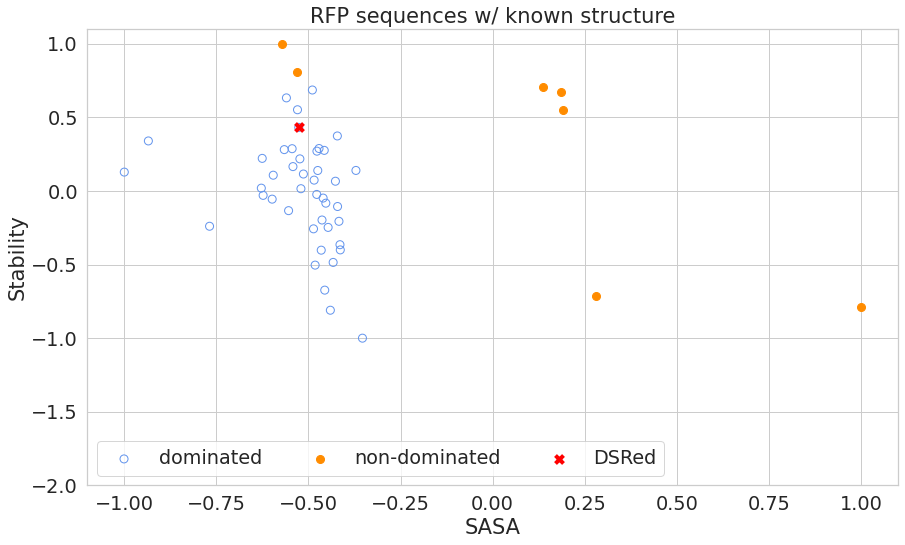

In [19]:
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1, 1, 1)

# trend not shown bc not statistically significant
# ax.plot(reg_x, reg_y, color='black', linestyle='--', linewidth=2, zorder=1)
ax.scatter(x_data[~pareto_mask], y_data[~pareto_mask], 
           s=64, facecolors='none', edgecolors='cornflowerblue', zorder=2, label='dominated')
ax.scatter(x_data[pareto_mask], y_data[pareto_mask], 
           s=64, label='non-dominated', color='darkorange', zorder=3)
ax.scatter(ref_x, ref_y, color='red', s=64, marker='x', label='DSRed',
           linewidth=4, zorder=2)

ax.set_xlabel('SASA')
ax.set_ylabel('Stability')
ax.legend(loc='lower left', ncol=3)
ax.set_xlim((-1.1, 1.1))
ax.set_ylim((-2, 1.1))

ax.set_title('RFP sequences w/ known structure')
plt.tight_layout()
# plt.savefig('./figures/rfp_known_structures_fitness_landscape_plot.pdf')

## Save results

Running this cell will overwrite the dataframe included in the repo.

In [ ]:
# rfp_known_structures.to_csv('../lambo/assets/fpbase/rfp_known_structures.csv', index=None)